# Analyze SARS-COV2 reads from Miseq (illumina) to get SARS-COV strain for samples

## Import and load stuff for python to work

In [84]:
%load_ext rmagic
import pandas as pd

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


## Be sure that your dependencies are installed :
- mamba 
- seqkit
- csvtk
- bbmap suite
- bwa
- samtools/sambamba
- bamaddrg
- freebayes

## Conda environment with dependencies

..TODO yaml file to upload to github repository 

## Have a look to the raw reads

Create a samples.txt file with samples name

In [3]:
%%bash
cd PRJNA673096
ls -1 > ../samples.txt
cd ../

Create a cvs file with seq numbers and min/max length

In [ ]:
%%bash
touch PRJNA673096.raw
for sample in `cat samples.txt`
do
seqkit stats PRJNA673096/${sample}/${sample}_1* | awk '!/file/{print $1,$4,$6,$8}' >> PRJNA673096.raw
done
cat  PRJNA673096.raw |sed -e "s/,//g" | sed -e "s/_1.fastq.gz//g" | sed -e "s/ /,/g" > PRJNA673096.csv
cat PRJNA673096.csv | csvtk add-header -n sample,number_reads,min_length,max_length > PRJNA673096_raw.csv
rm PRJNA673096.csv PRJNA673096.raw

Have a look of the fastq.gz raw files (number of reads and max_legnth)

array([[<AxesSubplot:title={'center':'number_reads'}>,
        <AxesSubplot:title={'center':'max_length'}>]], dtype=object)

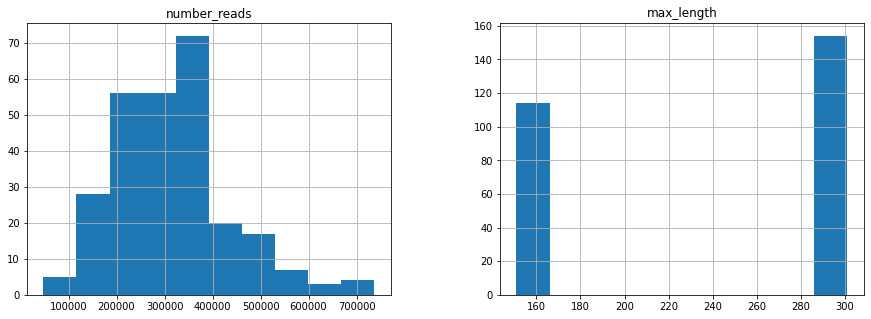

In [51]:
df1 = pd.read_csv("PRJNA673096_raw.csv")
df1.hist(column=['number_reads','max_length'],figsize=(15,5))

## QC analysis

Will qc everything below 20 en phread and all reads with less than 100 pb with bbmap

bbduk will take more than 1 core (not run in jupyter)

In [ ]:
%%bash 
ADAPTORS='~/working_directory/Useful_Files/adapters.fa'
for sample in `cat samples.txt`
do
bbduk.sh in=PRJNA673096/${sample}/${sample}_1.fastq.gz in2=PRJNA673096/${sample}/${sample}_2.fastq.gz out=01_QC/${sample}_Q1.fastq.gz out2=01_QC/${sample}_Q2.fastq.gz qtrim=r trimq=20 ref=$ADAPTORS maq=20 minlen=100
done

Check read lost with seqkit

In [88]:
%%bash
cd 01_QC
seqkit stats *_Q1.fastq.gz |  awk '!/file/{print $1,$4,$6,$8}' | sed -e "s/,//g" | 
sed -e "s/_1.fastq.gz//g"  | sed -e "s/ /,/g" | csvtk add-header -n sample,number_reads,min_length,max_length > ../PRJNA673096_QC.csv

## Mapping 

In [67]:
%%bash
cd ../

Steps in the loop:

    1. Mapping with bbmap (with some statistics and logs) -> constats.txt and basecov.txt
    2. Sorting and creating a bam file
    3. Mark PCR duplicates that result from exact duplication of a template during amplification (sambamba creates a index file too) 
    
** sambamba freeze in serine and not in alanine (do not run in serine nor valine)

In [ ]:
%%bash
bwa index wuhan.fasta
for sample in `cat samples.txt`
do
bwa mem wuhan.fasta 01_QC/${sample}_Q1.fastq.gz 01_QC/${sample}_Q2.fastq.gz  > 02_map/${sample}.sam 2> 02_map/${sample}.align.log
sambamba view -t 20 -S 02_map/${sample}.sam -f bam  | sambamba sort -o > 02_map/sorted_${sample}.bam 



sambamba markdup -t 30 $ 02_map/sorted_${sample}.bam 02_map/dup_${sample}_dup.bam
done

Move all qualite log txt to a folder (there are a lot of them). Also for sam.

In [ ]:
%%bash
mkdir 02_map/logs
mv 02_map/*txt 02_map/logs
mkdir 02_map/sam
mv 02_map/*sam 02_map/sam

Name your files for joint calling with bamaddrg

In [ ]:
%%bash
mkdir 02_map/final_bam
for sample in `cat samples.txt`
do
bamaddrg -b 02_map/${sample}_dup.bam -s ${sample} > 02_map/final_bam/${sample}_final.bam
# and re-index
samtools index 02_map/final_bam/${sample}_final.bam
done

## Creating a vcf from bam files with freebayes (joint calling)

making a bam variable storing all bam files

In [86]:
%%bash
cd 02_map/final_bam

In [ ]:
BAMs=`ls *bam | python -c 'import sys; print(" ".join([x.strip() for x in sys.stdin.readlines()]))'`

In [87]:
%%bash
freebayes -f ../../wuhan.fasta --gvcf --ploidy 1 -C 10 -L bam.list | bgzip >../../PRJNA673096.vcf.gz

'/WORKING_DIRECTORY/lvelo/covid19/MiSeq_Pipeline'

In [ ]:
pwd
